# Filtragem no Domínio da Frequência

## Introdução

O processamento de imagens digitais pode ser realizado em dois domínios principais: o `domínio espacial` (onde manipulamos diretamente os pixels da imagem) e o `domínio da frequência` (onde trabalhamos com a representação da imagem em termos de componentes de frequência).

### O Que São Frequências em Imagens?

Diferentemente do áudio, onde as frequências são facilmente compreendidas (graves e agudos), nas imagens o conceito de frequência pode ser menos intuitivo. Em uma imagem:

- **Baixas frequências**: Representam áreas onde a intensidade dos pixels varia lentamente (áreas homogêneas, como céu, paredes lisas)
- **Altas frequências**: Representam áreas com mudanças rápidas na intensidade dos pixels (bordas, detalhes finos, texturas e ruídos)

Por exemplo, uma imagem de um céu limpo contém principalmente componentes de baixa frequência, enquanto uma imagem de grama ou uma textura detalhada contém muitos componentes de alta frequência.

### Demonstração 

Vamos entender melhor com essa demonstração: [https://agostinhobritojr.github.io/apps/editablespectrum/](https://agostinhobritojr.github.io/apps/editablespectrum/)


**Objetivo:** - Conhecer e praticar filtragem no domínio da frequência.



## Transformada de Fourier

### Intuição

A Transformada de Fourier (TF) é uma ferramenta matemática que decompõe um sinal em suas componentes senoidais constituintes. Para imagens (sinais bidimensionais), usamos a Transformada de Fourier 2D.

A equação básica da Transformada Discreta de Fourier 2D (DFT) para uma imagem digital de tamanho M×N é:

$$ F(u,v) = \frac{1}{MN} \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) \times e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)} $$

Onde:
- `f(x,y)` é o valor do pixel na posição (x,y) da imagem
- `F(u,v)` é o coeficiente de Fourier na frequência (u,v)
- `e` é a base do logaritmo natural
- `j` é a unidade imaginária

Não se preocupe se esta equação parecer complexa. Na prática, utilizamos funções implementadas em bibliotecas como OpenCV e NumPy para calcular a DFT.

### Interpretação do Espectro de Fourier

Após aplicar a DFT, obtemos o **espectro de Fourier**, que contém:

1. **Magnitude**: Representa a "força" de cada componente de frequência
2. **Fase**: Representa o alinhamento ou deslocamento de cada componente

No espectro visualizado, tipicamente:
- O centro representa as baixas frequências (componente DC ou valor médio da imagem)
- À medida que nos afastamos do centro, encontramos as frequências mais altas
- A intensidade (brilho) de cada ponto indica a presença daquela frequência na imagem original

![](spectrum.png)


Em 3D temos a seguinte representação


![](spectrum3d.png)

## Implementação Prática da DFT

Em OpenCV, a função `cv2.dft()` calcula a Transformada Discreta de Fourier de uma imagem. O processo típico inclui:

1. Converter a imagem para ponto flutuante
2. Calcular a DFT usando `cv2.dft()`
3. Aplicar `np.fft.fftshift()` para mover o componente de frequência zero para o centro
4. Calcular o espectro de magnitude usando `cv2.magnitude()`
5. Aplicar logaritmo para melhorar a visualização (`np.log()`)

```python
# Exemplo básico
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
```

## Exibindo uma imagem no dominio da frequência

Na OpenCV usamos a função **cv2.dft()** 

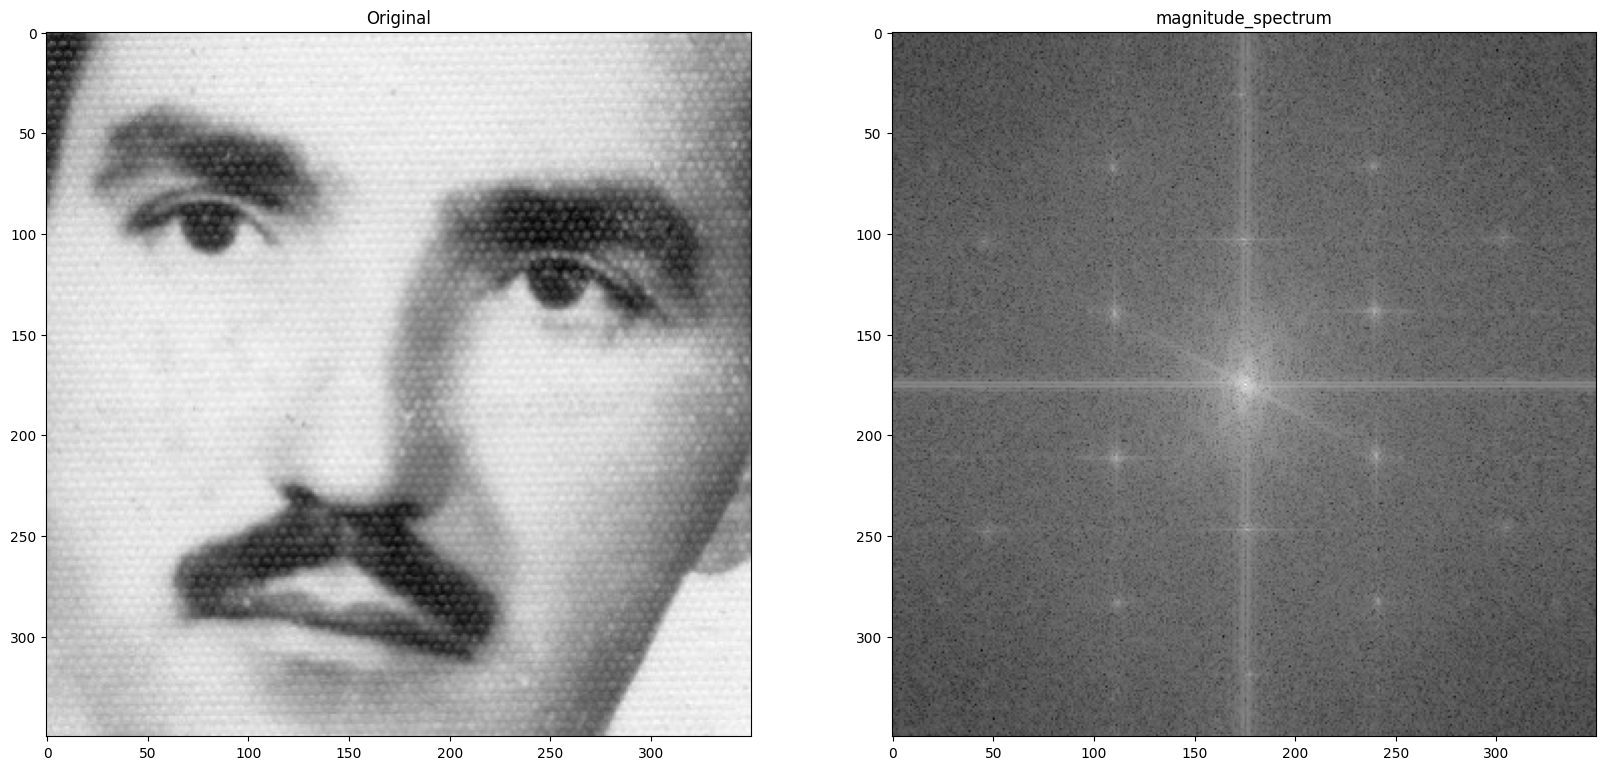

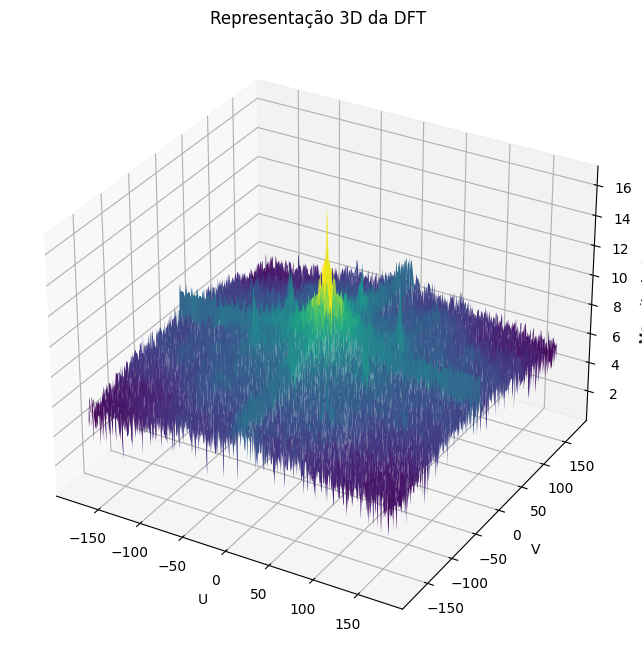

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


#carrega imagem
img = cv2.imread('lab_images/face.png',0) ## leio na escala de cinza,`` ,0``

# Transformação discreta de Fourier
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft = np.fft.fftshift(dft)


# Aplicado uma função log para visualização da magnitude do espectro
magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))


# Visualização das imagens
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1),plt.title('Original')
plt.imshow(img, cmap="gray")
plt.subplot(1, 2, 2),plt.title('magnitude_spectrum')
plt.imshow(magnitude_spectrum, cmap="gray")
plt.show()

# De forma complementar podemos visualizar o espectro 3D da imagem
# Para isso, vamos criar uma superfície 3D com base na magnitude do espectro
# A superfície será gerada a partir de um grid de pontos (X, Y) que representam as frequências
# O eixo Z será a magnitude do espectro
# A superfície será gerada com base no método plot_surface do matplotlib

rows, cols = img.shape
center_row, center_col = rows // 2, cols // 2

fig_3d = plt.figure(figsize=(10, 8))
ax = fig_3d.add_subplot(111, projection='3d')

x = np.linspace(-cols // 2, cols // 2 - 1, cols)
y = np.linspace(-rows // 2, rows // 2 - 1, rows)
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, magnitude_spectrum, cmap='viridis')
ax.set_title('Representação 3D da DFT')
ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('Magnitude (log)')

plt.show()


## Filtros no Domínio da Frequência

### Fundamentação Teórica

A filtragem no domínio da frequência baseia-se no **Teorema da Convolução**, que estabelece que a convolução no domínio espacial equivale à multiplicação no domínio da frequência:

f(x,y) * h(x,y) ⟷ F(u,v) × H(u,v)

Onde:
- f(x,y) é a imagem original
- h(x,y) é o kernel do filtro no domínio espacial
- F(u,v) é a transformada de Fourier da imagem
- H(u,v) é a transformada de Fourier do filtro (função de transferência)

Isso significa que podemos filtrar uma imagem seguindo estas etapas:
1. Calcular a DFT da imagem → F(u,v)
2. Multiplicar pelo filtro no domínio da frequência → F(u,v) × H(u,v)
3. Calcular a DFT inversa → resultado filtrado

## Filtro espectral

O **filtro espectral** (ou no **domínio das frequências**) usa o espectro da imagem para ressaltar ou atenuar determinadas carecterísticas de frequências da imagem. O mais comum é empregar filtros que manipulam diretamente a magnitude das frequências, que podem ser do tipo:
- **Filtro passa-baixas (PB):** realça baixas frequências e atenua as altas, multiplicando por valores baixos a magnitude das frequências maiores 
- **Filtro passa-altas (PA):** realça altas frequências e atenua as baixas, multiplicando por valores baixos a magnitude das frequências menores 
- **Filtro passa-faixa (PF):** realça uma região do espectro em torno de determinada frequência

### 1. Filtro Passa-Baixas (Low-Pass Filter)

**Definição**: Um filtro passa-baixas permite a passagem das baixas frequências e atenua ou elimina as altas frequências.

**Função de transferência ideal**:
```
H(u,v) = 1, se D(u,v) ≤ D₀
       = 0, se D(u,v) > D₀
```
Onde D(u,v) é a distância do ponto (u,v) ao centro do espectro, e D₀ é a frequência de corte.

**Função de transferência gaussiana** (mais suave e realista):

```
H(u,v) = e^(-D(u,v)²/2D₀²)
```

```python
mask = np.exp(-d_squared / (2 * (cutoff ** 2)))
```

**Aplicações**:
- Redução de ruído
- Suavização de imagens
- Redução de artefatos de alta frequência
- Desfoque (blur)

**Efeitos visuais**: Imagens mais suaves, com menos detalhes finos e bordas mais borradas.

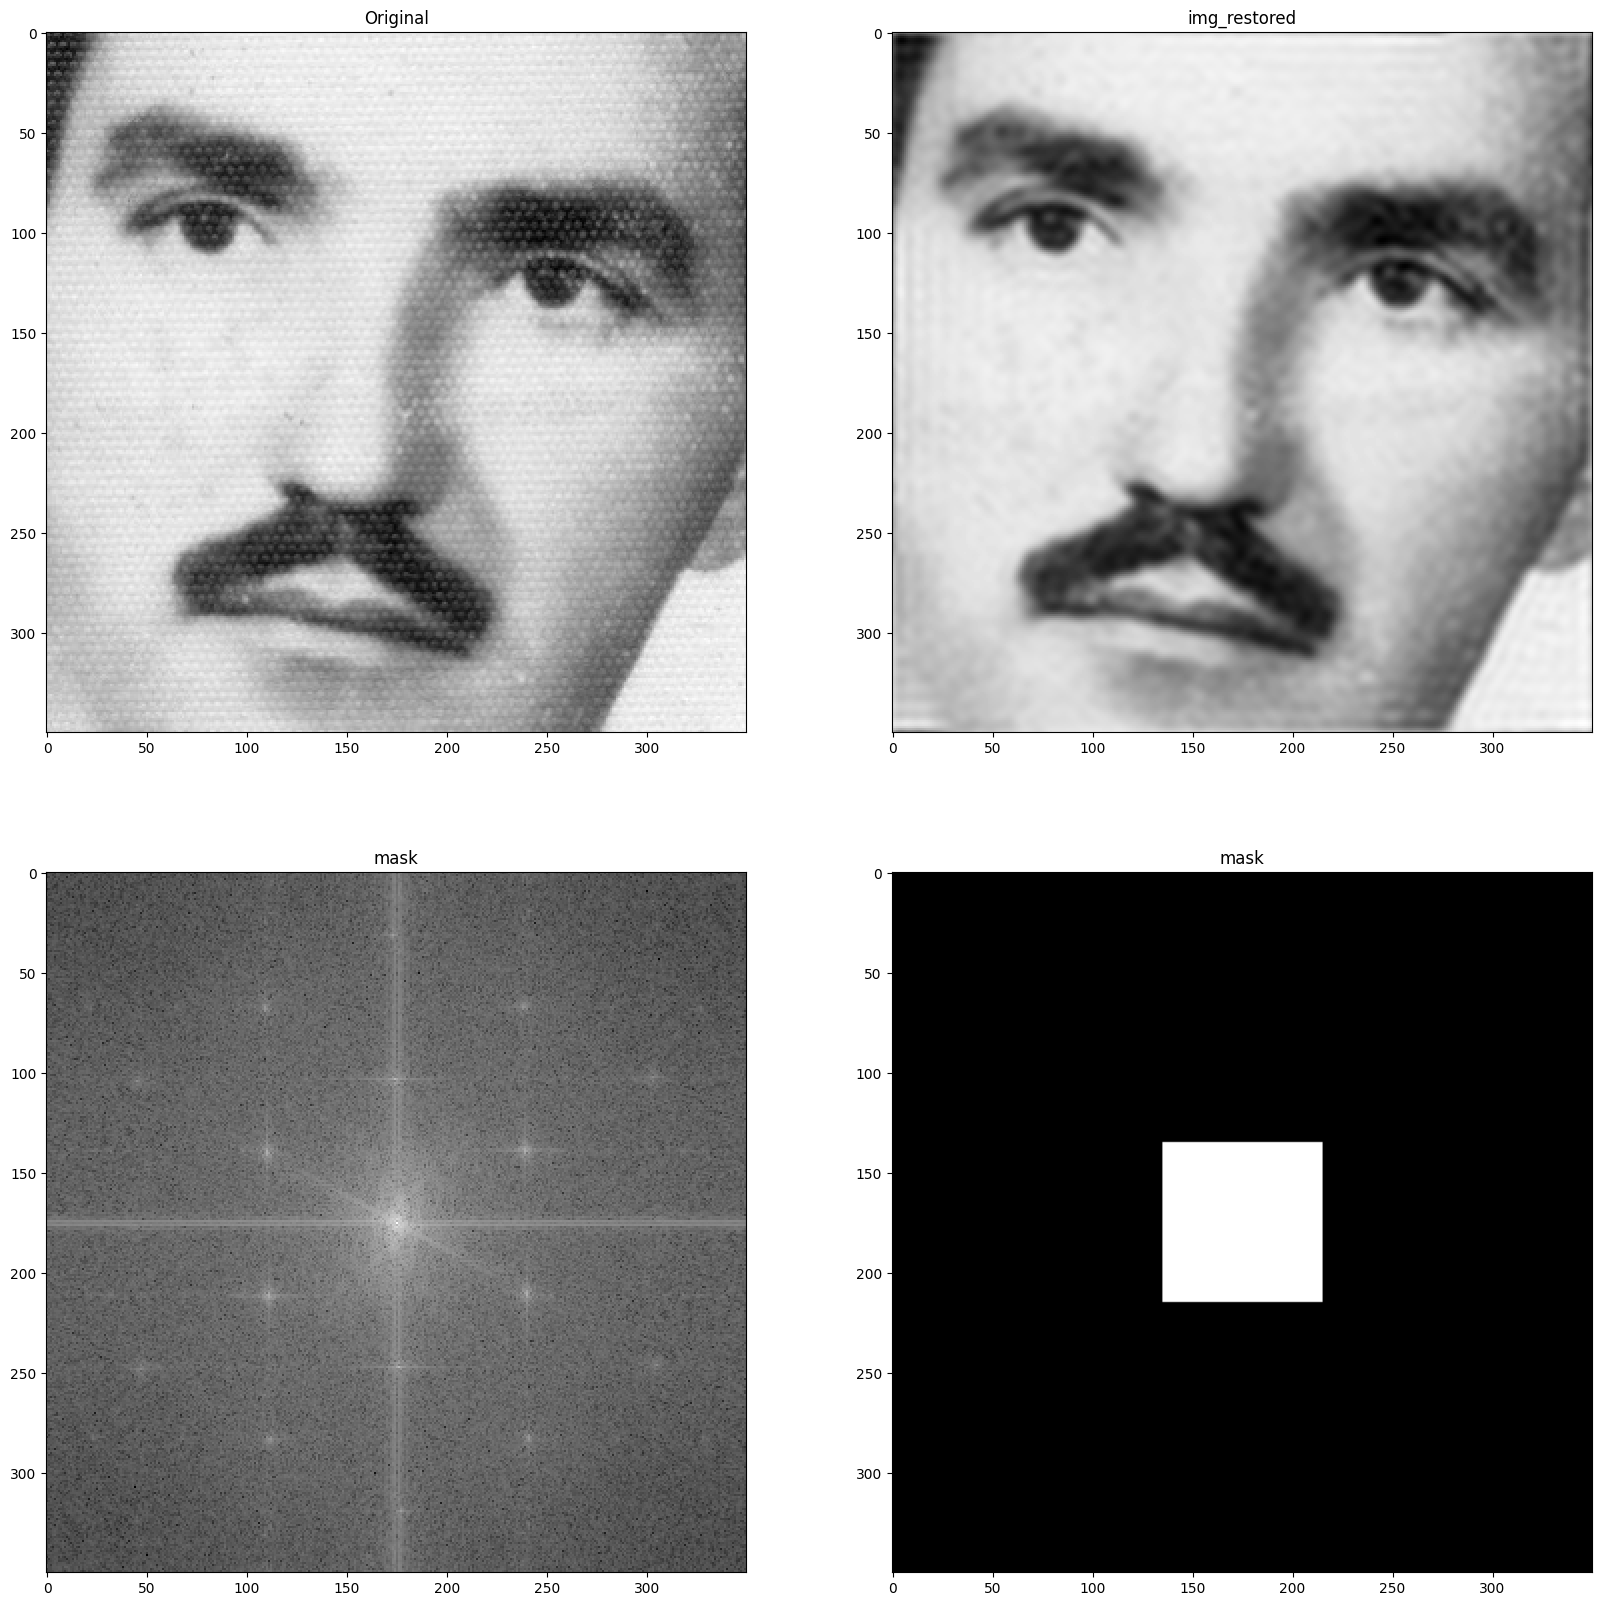

In [9]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


#carrega imagem
img = cv2.imread('lab_images/face.png',0)


# extraindo shape da imagem
rows, cols = img.shape
half_row, half_col = rows/2 , cols/2
limiar = 40 ### frequency cutoff frequencia de corte, 


# Criando a máscara quadrada
mask = np.zeros((rows,cols,2),np.uint8)
mask[int(half_row-limiar):int(half_row+limiar), int(half_col-limiar):int(half_col+limiar)] = 1


# Transformada discreta de Fourier
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft = np.fft.fftshift(dft)

# Aplicado uma função log para visualização da magnitude do espectro
magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))

# Aplicar filtro na imagem
dft_mask = dft*mask


# Transformada inversa de Fourier
dft_mask = np.fft.ifftshift(dft_mask)
img_restored = cv2.idft(dft_mask)
img_restored = cv2.magnitude(img_restored[:,:,0],img_restored[:,:,1])


# Visualização das imagens
fig = plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1),plt.title('Original')
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 4),plt.title('mask')
plt.imshow(mask[:,:,0], cmap="gray")
plt.subplot(2, 2, 2),plt.title('img_restored')
plt.imshow(img_restored, cmap="gray")
plt.subplot(2, 2, 3),plt.title('mask')
plt.imshow(magnitude_spectrum, cmap="gray")

plt.show()

### Aplicando um filtro de gaussiana



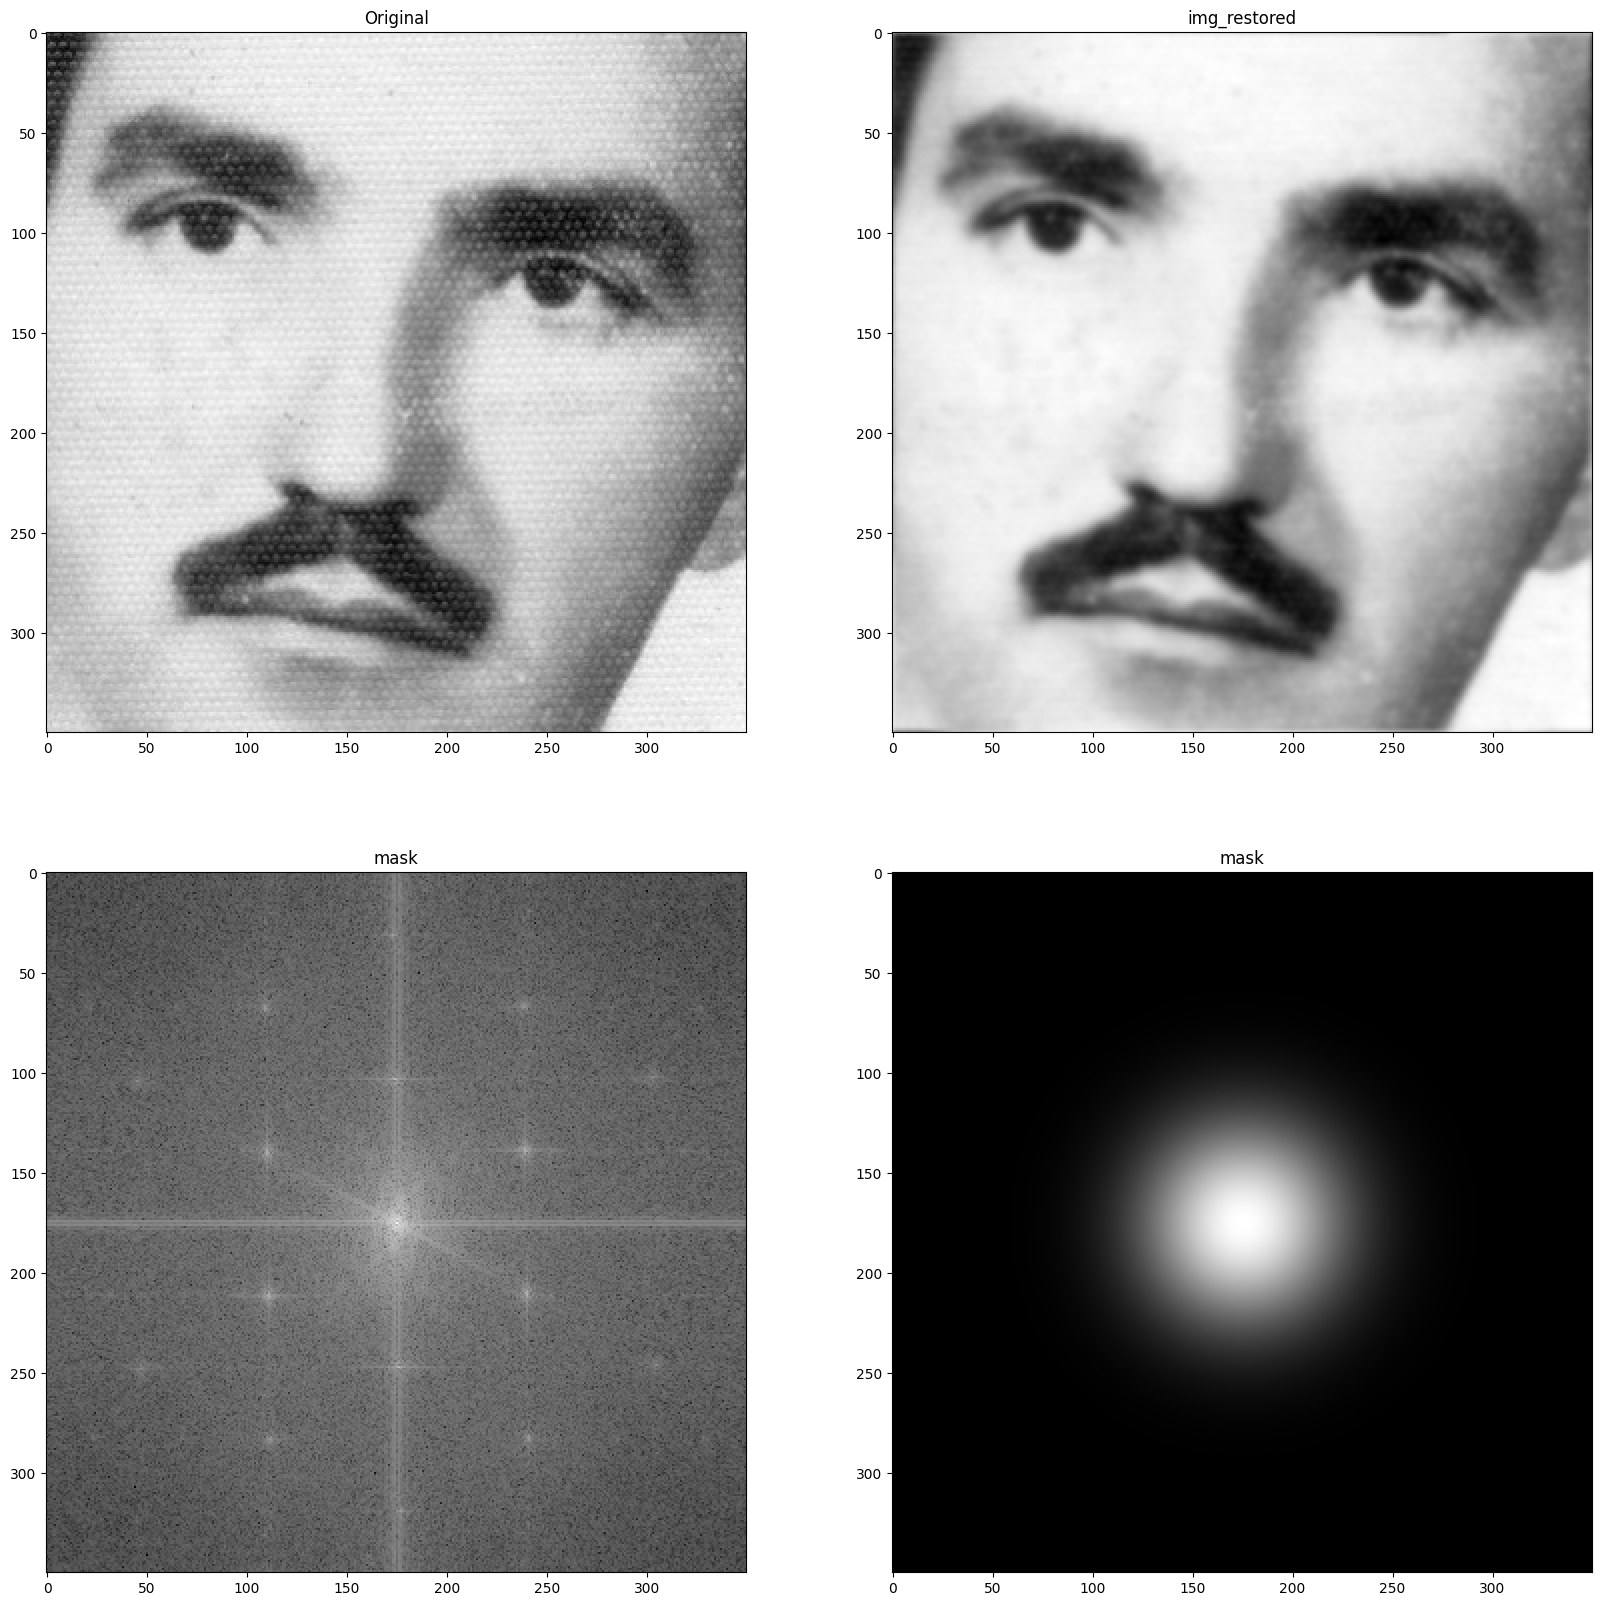

In [14]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


#carrega imagem
img = cv2.imread('lab_images/face.png',0)


# extraindo shape da imagem
rows, cols = img.shape
half_row, half_col = rows//2 , cols//2
limiar = 35

# Criando um filtro gaussiano
mask = np.zeros((rows,cols,2),np.uint8)
# Cria uma grade para calcular distâncias do centro
u = np.arange(rows)
v = np.arange(cols)
u, v = np.meshgrid(u - half_row, v - half_col, indexing='ij')
d_squared = u**2 + v**2
# Cria a máscara gaussiana
mask = np.exp(-d_squared / (2 * (limiar ** 2)))
# mask[int(half_row-limiar):int(half_row+limiar), int(half_col-limiar):int(half_col+limiar)] = 1
mask = np.dstack([mask, mask])


# Transformada discreta de Fourier
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft = np.fft.fftshift(dft)

# Aplicado uma função log para visualização da magnitude do espectro
magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))

# Aplicar filtro na imagem
dft_mask = dft*mask


# Transformada inversa de Fourier
dft_mask = np.fft.ifftshift(dft_mask)
img_restored = cv2.idft(dft_mask)
img_restored = cv2.magnitude(img_restored[:,:,0],img_restored[:,:,1])


# Visualização das imagens
fig = plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1),plt.title('Original')
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 4),plt.title('mask')
plt.imshow(mask[:,:,0], cmap="gray")
plt.subplot(2, 2, 2),plt.title('img_restored')
plt.imshow(img_restored, cmap="gray")
plt.subplot(2, 2, 3),plt.title('mask')
plt.imshow(magnitude_spectrum, cmap="gray")

plt.show()


### Filtro Passa-Altas (High-Pass Filter)

**Definição**: Um filtro passa-altas permite a passagem das altas frequências e atenua ou elimina as baixas frequências.

**Função de transferência ideal**:
```
H(u,v) = 0, se D(u,v) ≤ D₀
       = 1, se D(u,v) > D₀
```

**Função de transferência gaussiana**:
```
H(u,v) = 1 - e^(-D(u,v)²/2D₀²)
```

**Aplicações**:
- Detecção de bordas
- Realce de detalhes
- Nitidez (sharpening)
- Segmentação de imagens

**Efeitos visuais**: Destaca bordas e transições abruptas, removendo as áreas homogêneas.

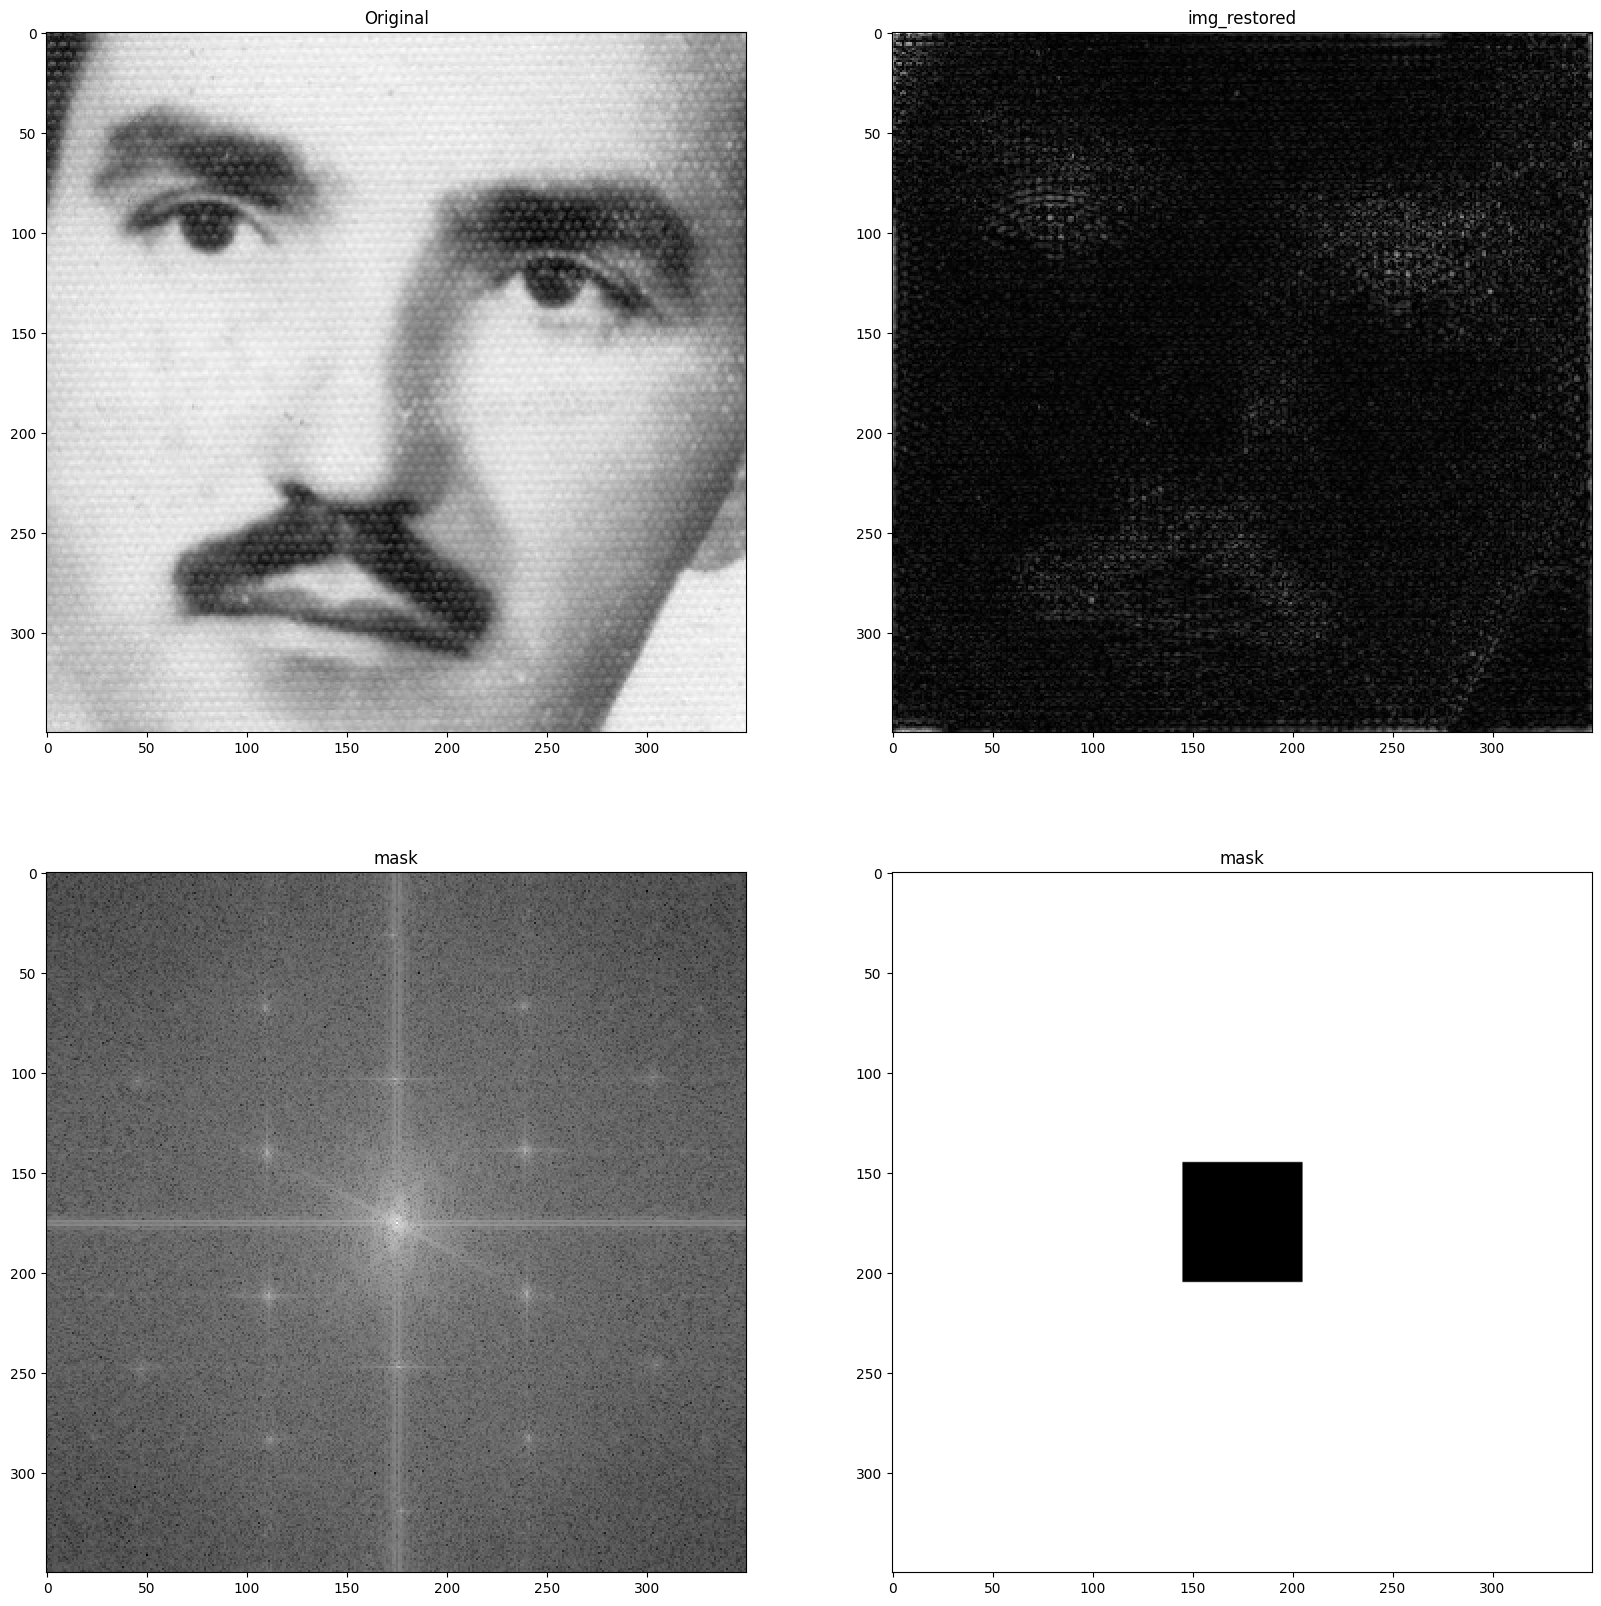

In [11]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


#carrega imagem
img = cv2.imread('lab_images/face.png',0)


# extraindo shape da imagem
rows, cols = img.shape
half_row, half_col = rows/2 , cols/2
limiar = 30


# Criando a máscara quadrada
mask = np.ones((rows,cols,2),np.uint8)
mask[int(half_row-limiar):int(half_row+limiar), int(half_col-limiar):int(half_col+limiar)] = 0


# Transformada discreta de Fourier
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft = np.fft.fftshift(dft)


# Aplicado uma função log para visualização da magnitude do espectro
magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))

# Aplicar filtro na imagem
dft_mask = dft*mask


# Transformada inversa de Fourier
dft_mask = np.fft.ifftshift(dft_mask)
img_restored = cv2.idft(dft_mask)
img_restored = cv2.magnitude(img_restored[:,:,0],img_restored[:,:,1])


# Visualização das imagens
fig = plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1),plt.title('Original')
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 4),plt.title('mask')
plt.imshow(mask[:,:,0], cmap="gray")
plt.subplot(2, 2, 2),plt.title('img_restored')
plt.imshow(img_restored, cmap="gray")
plt.subplot(2, 2, 3),plt.title('mask')
plt.imshow(magnitude_spectrum, cmap="gray")

plt.show()

### Filtro Passa-Faixa (Band-Pass Filter)

**Definição**: Um filtro passa-faixa permite a passagem de um intervalo específico de frequências e atenua frequências fora desse intervalo.

**Função de transferência ideal**:
```
H(u,v) = 1, se D₁ ≤ D(u,v) ≤ D₂
       = 0, caso contrário
```
Onde D₁ e D₂ são as frequências de corte inferior e superior.

**Aplicações**:
- Isolamento de texturas específicas
- Remoção de padrões periódicos (como moiré)
- Análise de componentes específicos da imagem

**Efeitos visuais**: Preserva estruturas com determinada escala espacial, eliminando tanto detalhes muito finos quanto áreas muito homogêneas.

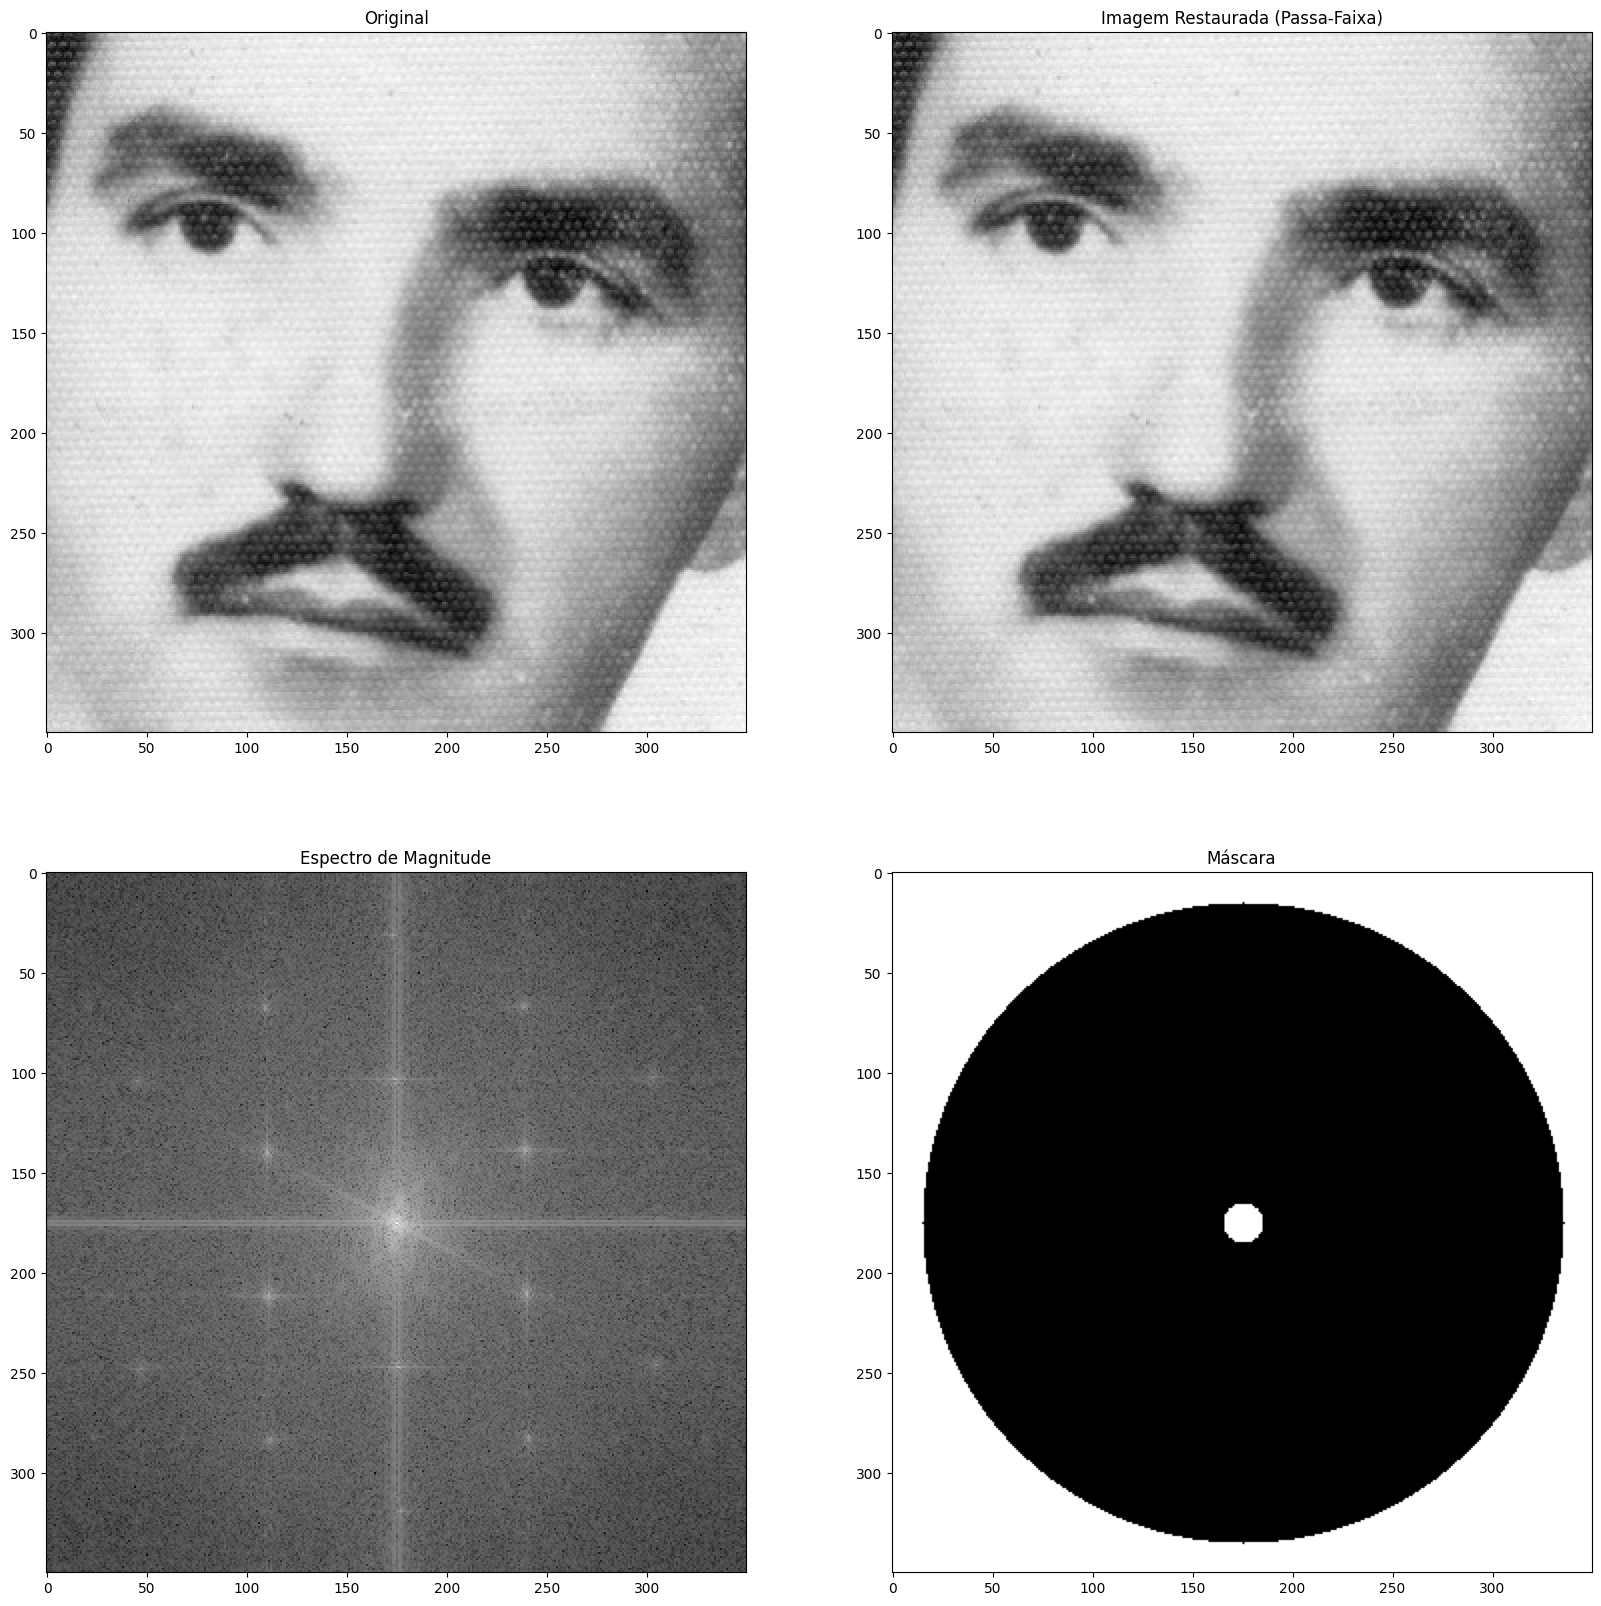

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Carrega imagem em escala de cinza
img = cv2.imread('lab_images/face.png', 0)

# Extraindo shape da imagem
rows, cols = img.shape
half_row, half_col = rows // 2, cols // 2  # Usar divisão inteira para evitar floats

# Definir os raios para o filtro passa-faixa
inner_radius = 10  # Raio interno (exclui frequências muito baixas)
outer_radius = 160  # Raio externo (exclui frequências muito altas)

# Criando a máscara para o filtro passa-faixa
mask = np.zeros((rows, cols, 2), np.uint8)
for i in range(rows):
    for j in range(cols):
        # Calcular a distância ao centro
        distance = np.sqrt((i - half_row)**2 + (j - half_col)**2)
        if inner_radius <= distance <= outer_radius:
            mask[i, j] = 1
mask = 255 - mask
# Transformada discreta de Fourier
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft = np.fft.fftshift(dft)

# Aplicando uma função log para visualização da magnitude do espectro
magnitude_spectrum = np.log(1 + cv2.magnitude(dft[:, :, 0], dft[:, :, 1]))  # Adicionar 1 para evitar log(0)

# Aplicar filtro na imagem
dft_mask = dft * mask

# Transformada inversa de Fourier
dft_mask = np.fft.ifftshift(dft_mask)
img_restored = cv2.idft(dft_mask)
img_restored = cv2.magnitude(img_restored[:, :, 0], img_restored[:, :, 1])

# Visualização das imagens
fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1), plt.title('Original')
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 2), plt.title('Imagem Restaurada (Passa-Faixa)')
plt.imshow(img_restored, cmap="gray")
plt.subplot(2, 2, 3), plt.title('Espectro de Magnitude')
plt.imshow(magnitude_spectrum, cmap="gray")
plt.subplot(2, 2, 4), plt.title('Máscara')
plt.imshow(mask[:, :, 0], cmap="gray")

plt.show()

## DESAFIO1

Aplique diferentes tipos de filtros no domínio da frequência e analise os resultados.

Implemente três tipos de filtros no domínio da frequência ajustando a frequência de corte:

- Filtro passa-baixa.
- Filtro passa-alta.
- Filtro passa-faixa.

![](carro.png)

## DESAFIO2 

Escolha uma imagem e um tipo de filtro (exemplo: passa-baixa).

Implemente o filtro:
- No domínio espacial, usando convolução.
- No domínio da frequência, usando a transformada de Fourier.

Compare os resultados em termos de:
- Qualidade da imagem filtrada.
- Tempo de processamento.

![](casa.png)